In [ ]:
torch.cuda.empty_cache()

In [1]:
import scipy.io
import os
import shutil
try:
    from urllib import urlretrieve # python2
except:
    from urllib.request import urlretrieve # python3

In [2]:
import data as data
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch
device = T.device("cuda")  # apply to Tensor or Module
import time
from tqdm import tqdm

In [3]:
mat = scipy.io.loadmat( 'PaviaU.mat' )
img = mat[ 'paviaU' ]

# create a hyperspectral dataset object from the numpy array
hypData = data.HypImg( img )

# pre-process data to make the model easier to train
hypData.pre_process( 'minmax' )

In [4]:
img.shape

(610, 340, 103)

In [5]:
# create data iterator objects for training and validation using the pre-processed data
trainSamples = 200000
valSamples = 100
dataTrain = data.Iterator( dataSamples=hypData.spectraPrep[:trainSamples, :],
                        targets=hypData.spectraPrep[:trainSamples, :], batchSize=4 )
dataVal = data.Iterator( dataSamples=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :],
                        targets=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :] )


In [6]:
# shuffle training data
dataTrain.shuffle()

In [7]:
train_data = torch.tensor(dataTrain.dataSamples.astype(np.float32))
train_data

tensor([[1.6273e-01, 4.9164e-07, 4.0315e-02,  ..., 3.7856e-01, 3.8496e-01,
         3.8938e-01],
        [3.7848e-01, 2.6654e-01, 2.5108e-01,  ..., 6.7471e-01, 6.7842e-01,
         6.7656e-01],
        [1.2317e-01, 1.2358e-01, 3.0082e-02,  ..., 5.7724e-01, 5.7886e-01,
         5.9512e-01],
        ...,
        [1.9100e-01, 1.4544e-01, 4.4977e-02,  ..., 9.2202e-01, 9.3779e-01,
         9.3429e-01],
        [3.3835e-01, 2.1405e-01, 3.1216e-02,  ..., 7.2185e-01, 7.1070e-01,
         7.1070e-01],
        [1.6822e-01, 1.6489e-01, 7.6102e-02,  ..., 6.3017e-01, 6.1949e-01,
         6.2417e-01]])

In [8]:
hypData.numBands
encoderSize=[50,30,10]
encoderSize=[hypData.numBands]+encoderSize
decodersize=encoderSize[::-1]
encoderSize,decodersize

([103, 50, 30, 10], [10, 30, 50, 103])

In [9]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [10]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enn1 = T.nn.Linear(103, 50)  # 64-16-2-16-64
    self.enn2 = T.nn.Linear(50, 30)
    self.enn3 = T.nn.Linear(30,10)
    self.dnn3 = T.nn.Linear(10, 30)  # 64-16-2-16-64
    self.dnn2 = T.nn.Linear(30, 50)
    self.dnn1 = T.nn.Linear(50,103)

  def encoder(self,x):
    z= T.relu(self.enn1(x))
    z= T.relu(self.enn2(z))
    z= T.relu(self.enn3(z))
    return z
  
  def decoder(self,x):
    z= T.relu(self.dnn3(x))
    z= T.relu(self.dnn2(z))
    z= self.dnn1(z)
    return z


  def forward(self, x):
    z=self.encoder(x)
    z= self.decoder(z)
    
    return z
net=Net().to(device)
inpu=torch.rand(1,103).to(device)
outp=net(inpu)
outp.shape


torch.Size([1, 103])

In [ ]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 8184
train_ldr = T.utils.data.DataLoader(train_data,
batch_size=bat_size, shuffle=True)
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 100
ep_log_interval = 5
lrn_rate = 0.0001

loss_func1 = T.nn.MSELoss()
loss_func = T.nn.MSELoss()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()


for epoch in range(0, max_epochs):
  time.sleep(0.5)
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0
  for (batch_idx, batch) in loop:
    X = batch.to(device)  # no targets needed

    optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt, X)  # note: X not Y
    loss_obj1=loss_func1(oupt,X)
    epoch_loss += loss_obj.item()  # accumulate
    mseloss+=loss_obj1.item()
    loss_obj.backward()
    optimizer.step()
    
    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss),mseloss=str(mseloss))

    

  #if epoch % ep_log_interval == 0:
    
    
    #print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()





In [ ]:
loss_obj

In [ ]:

torch.save(net, 'model_mse.pth')

In [ ]:
torch.save(net.state_dict(), 'net_model_mse.pth')

In [11]:
net.load_state_dict(torch.load('net_model_mse.pth'))

<All keys matched successfully>

In [12]:
trex=torch.tensor(hypData.spectraPrep.astype(np.float32))
trex

tensor([[0.1428, 0.1011, 0.0913,  ..., 0.8679, 0.8727, 0.8761],
        [0.1670, 0.1465, 0.1398,  ..., 0.8144, 0.8221, 0.8447],
        [0.2236, 0.2766, 0.1961,  ..., 0.9382, 0.9538, 0.9606],
        ...,
        [0.1139, 0.0292, 0.0460,  ..., 0.8492, 0.8594, 0.8660],
        [0.1068, 0.1744, 0.1333,  ..., 0.8415, 0.8397, 0.8316],
        [0.2278, 0.1603, 0.0520,  ..., 0.8381, 0.8505, 0.8657]])

In [13]:
dataZ=net.encoder(trex.to("cuda"))
dataZ.shape

torch.Size([207400, 10])

In [14]:
dataY = net.decoder(dataZ)
dataY.shape

torch.Size([207400, 103])

In [15]:
imgZ = np.reshape(dataZ.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [16]:
imgZ.shape

(610, 340, 10)

In [17]:
imgY = np.reshape(dataY.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))
tensory=dataY.reshape(hypData.numRows, hypData.numCols, -1)
tensory.shape

torch.Size([610, 340, 103])

In [18]:
imgX = np.reshape(hypData.spectraPrep, (hypData.numRows, hypData.numCols, -1))
tensorx=torch.Tensor(imgX)

In [19]:
imgX.shape

(610, 340, 103)

In [20]:
hypData.spectraPrep.shape

(207400, 103)

In [21]:
# visualise latent image using 3 out of the 10 dimensions
colourImg = imgZ.copy()
colourImg = colourImg[ :,:,np.argsort(-np.std(np.std(colourImg, axis=0), axis=0))[:3] ]
colourImg /= np.max(np.max(colourImg, axis=0), axis=0)

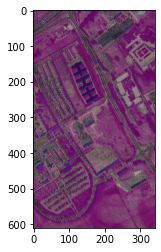

In [22]:
plt.imshow(colourImg)

Text(0.5, 1.0, 'meadow spectra')

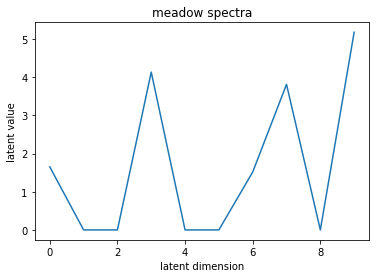

In [23]:
# save plot of latent vector of 'meadow' spectra
fig = plt.figure()
plt.plot(imgZ[576, 210, :])
plt.xlabel('latent dimension')
plt.ylabel('latent value')
plt.title('meadow spectra')

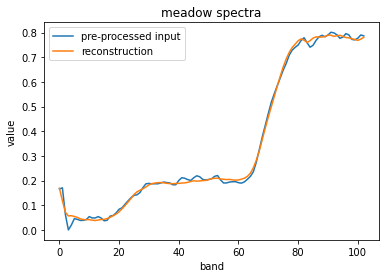

In [24]:
# save plot comparing pre-processed 'meadow' spectra input with decoder reconstruction
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(hypData.numBands),imgX[576, 210, :],label='pre-processed input')
ax.plot(range(hypData.numBands),imgY[576, 210, :],label='reconstruction')
plt.xlabel('band')
plt.ylabel('value')
plt.title('meadow spectra')
ax.legend()

In [25]:
 #--------- visualisation ----------------------------------------

 # download dataset ground truth pixel labels (if already downloaded, comment this out).
 urlretrieve( 'http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat',
                         os.path.join(os.getcwd(), 'PaviaU_gt.mat') )

('c:\\Users\\naras\\Model_train\\MLP-Autoenc\\PaviaU_gt.mat',
 <http.client.HTTPMessage at 0x2188d5546a0>)

In [26]:
# read labels into numpy array
mat_gt = scipy.io.loadmat( 'PaviaU_gt.mat' )
img_gt = mat_gt['paviaU_gt']
gt = np.reshape( img_gt , ( -1 ) )
gt

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [27]:
dataZ.detach()

tensor([[0.9095, 0.0000, 0.0000,  ..., 3.1624, 0.0000, 4.2269],
        [1.0933, 0.0000, 0.0000,  ..., 3.1627, 0.0000, 4.3015],
        [1.0379, 0.0000, 0.0000,  ..., 3.3063, 0.0000, 4.1848],
        ...,
        [1.2522, 0.0000, 0.0000,  ..., 3.4875, 0.0000, 4.7604],
        [1.3364, 0.0000, 0.0000,  ..., 3.3491, 0.0000, 4.7228],
        [1.2908, 0.0000, 0.0000,  ..., 3.3046, 0.0000, 4.7423]],
       device='cuda:0')

In [28]:
imz=imgZ
imz = imz[:,:,0]
imz=imz.reshape(-1)
imz.shape

(207400,)

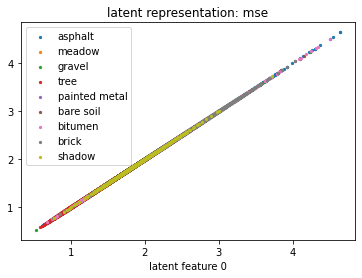

In [29]:
dataZ_collection = [imz]

for j,dataZ in enumerate(dataZ_collection):
    # save a scatter plot image of 2 of 3 latent dimensions
    std_dZ = -np.std(imz,axis=0)
    idx = np.argsort(std_dZ)
    fig, ax = plt.subplots()
    for i,gt_class in enumerate(['asphalt', 'meadow', 'gravel','tree','painted metal','bare soil','bitumen','brick','shadow']):
     ax.scatter(imz[gt == i+1], imz[gt == i+1], c='C%i'%i,s=5,label=gt_class)
    ax.legend()
    plt.title('latent representation: mse')
    plt.xlabel('latent feature %i' % (idx[0]))
#    plt.ylabel('latent feature %i' % (idx[1]))

In [37]:
idx.shape

(1,)

In [30]:
from math import log10, sqrt
import numpy as np
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def main():
     original = imgX[576, 210, :]
     compressed = imgY[576, 210, :]
     value = PSNR(original, compressed)
     print(f"PSNR value is {value} dB")
       
if __name__ == "__main__":
    main()

PSNR value is 85.5612955603251 dB


In [31]:
psnr=[]
import statistics
for i in range(hypData.numBands):
    original = imgX[:, :, i]
    compressed = imgY[:, :, i]
    value = PSNR(original, compressed)
    psnr.append(value)
    

print(f" Mean PSNR value is {statistics.mean(psnr)} dB")

 Mean PSNR value is 83.10509027695566 dB


In [35]:
from skimage.metrics import structural_similarity
##skimage.metrics.
import argparse
import imutils
import cv2



# 3. Load the two input images
imageA = imgX[:, :, 1]
imageB = imgY[:, :, 1]

# 4. Convert the images to grayscale
#grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
#grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)


In [36]:

# 5. Compute the Structural Similarity Index (SSIM) between the two
#    images, ensuring that the difference image is returned
(score, diff) = structural_similarity(imageA, imageB, full=True)
diff = (diff * 255).astype("uint8")

# 6. You can print only the score if you want
print("SSIM: {}".format(score))

SSIM: 0.896207596233283


In [37]:
import pytorch_ssim
import torch
from torch.autograd import Variable
from torch import optim

In [47]:
img1 = Variable(tensorx)
img2 = Variable(tensory)
ssim_value = 1-pytorch_ssim.ssim(imageA, imageB,103).item()